<a href="https://colab.research.google.com/github/MohsenSadeghi/ml_course/blob/main/notebooks/notebook_2_protein_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import pickle, glob, urllib

In [2]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

cuda0 = torch.device('cuda:0')
cpu0 = torch.device('cpu:0')

Is CUDA available: True
CUDA version: 11.3
PyTorch version: 1.12.1+cu113
CUDA device name: Tesla T4


### By chaning ```save_net``` and ```load_net``` boolean variables, you can change/access the saved weights.
### The ```train_net``` variable enables/disable the training loop.

In [3]:
save_net = False
train_net = True
load_net = True

### Loading the table of sequence - protein class data from file

In [4]:
if not glob.glob("./apolipo_dataset.pickle") :

        print("Downloading dataset...")
        
        urllib.request.urlretrieve('https://ftp.mi.fu-berlin.de/pub/cmb-data/mohsen_data/apolipo_dataset.pickle',
                                   './apolipo_dataset.pickle')
        
with open('./apolipo_dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [5]:
_color = '\033[94m'
_end_color = '\033[0m'

for i in [0, -1]:
    print(f"{_color} sequence = {_end_color} {dataset['sequence'][i]}")
    print(f"{_color} does sequence belong to an apolipoproteins? {_end_color} {dataset['class'][i] == 1}")
    print("-" * 50)

 sequence =  MKAAVLTLAVLFLTGSQARHFWQQDEPPQSPWDRVKDLATVYVDVLKDSGRDYVSQFEGSALGKQLNLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEMELYRQKVEPLRAELQEGARQKLHELQEKLSPLGEEMRDRARAHVDALRTHLAPYSDELRQRLAARLEALKENGGARLAEYHAKATEHLSTLSEKAKPALEDLRQGLLPVLESFKVSFLSALEEYTKKLNTQ
 does sequence belong to an apolipoproteins?  True
--------------------------------------------------
 sequence =  MACIYPTTFYTSLPTKSLNMGISLTTILILSVAVLLSTAAPPSCRECYQSLHYRGEMQQYFTYHTHIERSCYGNLIEECVESGKSYYKVKNLGVCGSRNGAICPRGKQWLCFTKIGQWGVNTQVLEDIKREQIIAKAKASKPTTPPENRPRHFHSFIQKL
 does sequence belong to an apolipoproteins?  False
--------------------------------------------------


### The Tokenizer

we want to assign numbers to the letters used in the alphabet (in this case, protein sequences)

In [6]:
seq_text = ""

for seq in dataset["sequence"]:
    seq_text = seq_text + seq
    
chars = tuple(set(seq_text))

int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

print(f"alphabet = {chars}")
print(f"alphabet length = {len(chars)}")
non_code = len(chars)

dataset["encoded_sequence"] = []

for _seq in dataset["sequence"]:
    encoded = np.array([char2int[ch] for ch in _seq], dtype=np.int32)
    
    dataset["encoded_sequence"].append(encoded)

alphabet = ('R', 'Y', 'D', 'L', 'T', 'K', 'S', 'I', 'H', 'F', 'W', 'N', 'C', 'Q', 'M', 'G', 'E', 'P', 'A', 'V')
alphabet length = 20


In [7]:
for i in [0, -1]:
    print(f"{_color} sequence = {_end_color} {dataset['encoded_sequence'][i]}")
    print(f"{_color} does sequence belong to an apolipoproteins? {_end_color} {dataset['class'][i] == 1}")
    print("-" * 50)

 sequence =  [14  5 18 18 19  3  4  3 18 19  3  9  3  4 15  6 13 18  0  8  9 10 13 13
  2 16 17 17 13  6 17 10  2  0 19  5  2  3 18  4 19  1 19  2 19  3  5  2
  6 15  0  2  1 19  6 13  9 16 15  6 18  3 15  5 13  3 11  3  5  3  3  2
 11 10  2  6 19  4  6  4  9  6  5  3  0 16 13  3 15 17 19  4 13 16  9 10
  2 11  3 16  5 16  4 16 15  3  0 13 16 14  6  5  2  3 16 16 19  5 18  5
 19 13 17  1  3  2  2  9 13  5  5 10 13 16 16 14 16  3  1  0 13  5 19 16
 17  3  0 18 16  3 13 16 15 18  0 13  5  3  8 16  3 13 16  5  3  6 17  3
 15 16 16 14  0  2  0 18  0 18  8 19  2 18  3  0  4  8  3 18 17  1  6  2
 16  3  0 13  0  3 18 18  0  3 16 18  3  5 16 11 15 15 18  0  3 18 16  1
  8 18  5 18  4 16  8  3  6  4  3  6 16  5 18  5 17 18  3 16  2  3  0 13
 15  3  3 17 19  3 16  6  9  5 19  6  9  3  6 18  3 16 16  1  4  5  5  3
 11  4 13]
 does sequence belong to an apolipoproteins?  True
--------------------------------------------------
 sequence =  [14 18 12  7  1 17  4  4  9  1  4  6  3 17  4  5  6  3 11 

### Additionally, we crop the sequence at 200 residues

Hopefully, the classifier can pick the class from the cropped sequence as well.

In [8]:
fixed_length = 200

dataset["cropped_sequence"] = []

for _seq in dataset["encoded_sequence"]:
    
    if len(_seq) < fixed_length:
        dataset["cropped_sequence"].append(np.pad(_seq, (0, fixed_length - len(_seq)), constant_values=non_code))
    else:
        dataset["cropped_sequence"].append(_seq[:fixed_length].copy())

In [9]:
for _seq in dataset["cropped_sequence"]:
    assert len(_seq) == fixed_length

### The following is an implementation of a "classifier" network

It is composed of:
- an Embedding layer (which translates the sequence into vectors of dimension ```embedding_dim```)
- several one-dimensional Convolutional layers
- a series of Dense layers acting on the flattened output of the last convolutional layer

ReLU is used as the activation function throughout the network.

Dropout is applied on the weights of the Dense layers to prevent overfitting.

In [10]:
class ProteinClassifierNet(nn.Module):

    def __init__(self, input_size, n_classes,
                 embedding_dim=5, 
                 conv_layers_kernel_sizes = [3, 3, 3],
                 conv_layers_n_filters = [16, 16, 4],
                 dense_layers_dim=[128, 32, 8]):

        super(ProteinClassifierNet, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings=non_code + 1,
                                            embedding_dim=embedding_dim)
        
        self.conv_layers = nn.ModuleList()
        current_n_channels = embedding_dim
        
        for _kernel_size, _n_filters in zip(conv_layers_kernel_sizes, conv_layers_n_filters):
            self.conv_layers.append(nn.Conv1d(in_channels=current_n_channels,
                                              out_channels=_n_filters,
                                              padding=_kernel_size // 2,
                                              kernel_size=_kernel_size))
            
            current_n_channels = _n_filters
        
        self.dense_layers = nn.ModuleList()
        current_dim = current_n_channels * input_size
        
        for _dim in dense_layers_dim:
            
            self.dense_layers.append(nn.Linear(in_features=current_dim,
                                          out_features=_dim, bias=True))
            self.dense_layers
            current_dim = _dim
        
        self.dropout_layer = nn.Dropout(0.5)
        
        self.final_layer = nn.Linear(in_features=current_dim, out_features=n_classes, bias=True)
     
    def forward(self, x, **kwargs):
    
        x = self.embedding(x)
        
        x = torch.transpose(x, 1, 2)
        
        for _lay in self.conv_layers:
            x = torch.relu(_lay(x, **kwargs))
        
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        
        for _lay in self.dense_layers:
            x = self.dropout_layer(torch.relu(_lay(x, **kwargs)))

        x = self.final_layer (x)
        
        return x

### Preparing datasets to be fed to the network for training and validation

We use an 90% - 10% split between training and validation data.

The data is being randomly partitioned and used in the training loop. This is a simple example of the **Holdout** cross-validation method.

The ```batch_size``` can be adjusted to change the stochasticity of the gradient descent procedure.

In [11]:
batch_size = 8

torch_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(dataset["cropped_sequence"])).to(cuda0),
           torch.from_numpy(np.array(dataset["class"])).to(cuda0))

In [12]:
n_train_data = int(np.ceil(0.9 * len(torch_dataset)))
n_validation_data = len(torch_dataset) - n_train_data

### Constructing an instance of the network

with the given embedding dimensions, and the output dimension of 2, for two-class predictions.

In [13]:
net = ProteinClassifierNet (input_size=fixed_length, n_classes=2, embedding_dim=5).to(cuda0)

print(net)

ProteinClassifierNet(
  (embedding): Embedding(21, 5)
  (conv_layers): ModuleList(
    (0): Conv1d(5, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(16, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (dense_layers): ModuleList(
    (0): Linear(in_features=800, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=8, bias=True)
  )
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (final_layer): Linear(in_features=8, out_features=2, bias=True)
)


### This is "Adam", our optimizer.

This is an enhanced version of a gradient-descent optimizer.

The learning rate is set to be 5E-5.

In [14]:
optimizer = torch.optim.AdamW(net.parameters(), lr=5.0e-5)

### The loss function

The characteristic loss function used in classification tasks is the so-called **Cross-Entropy** loss.

In [15]:
loss_function = nn.CrossEntropyLoss(reduction='mean')

This is a helper function to calculate the accuracy of class predictions on either of the training or validation datasets.

In [16]:
def calc_accuracy(net, data_loader, n_classes):

    correct_hit = 0.0
    total_hit = 0.0

    net.eval()

    with torch.no_grad():

        for i, (input_data, target_data) in enumerate(data_loader):

            outputs = torch.nn.functional.softmax(net(input_data), dim=1)

            predicted = torch.argmax(outputs, dim=1)

            for _t, _p in zip(target_data.cpu().numpy(), predicted.cpu().numpy()):

                total_hit += 1.0

                if _t == _p:

                    correct_hit += 1.0

    return correct_hit / total_hit

Getting things ready for the training loop:

In [17]:
n_epochs = 100

gathered_loss = {'training': [], 'validation': [], 'accuracy': []}

### The training loop

We continue the training until:

- the network starts to overfit (validation loss starts to gain on training loss)
- we reach a maximum number of epochs

In [20]:
if train_net:
    
    epoch = 0
    _accuracy = 0.0
    _mean_train_loss = 0.0
    _mean_val_loss = -1.0
    
    while _mean_val_loss < 1.4 * _mean_train_loss and epoch < n_epochs:

        train_data, validation_data = torch.utils.data.random_split(torch_dataset, [n_train_data, n_validation_data])

        train_dataset = torch.utils.data.DataLoader(train_data, batch_size, drop_last=False)
        validation_dataset = torch.utils.data.DataLoader(validation_data, batch_size, drop_last=False)

        train_loss = []

        net.train()

        for i, (input_data, target_data) in enumerate(train_dataset):

            optimizer.zero_grad()

            output_data = net(input_data)
            
            _loss = loss_function(output_data, target_data)

            _loss.backward()

            optimizer.step()

            train_loss.append(_loss.item())
        
        _mean_train_loss = np.mean(train_loss)
        
        gathered_loss['training'].append(_mean_train_loss)

        validation_loss = []

        net.eval()

        with torch.no_grad():

            for (input_data, target_data) in validation_dataset:

                optimizer.zero_grad()

                output_data = net(input_data)

                _loss = loss_function(output_data, target_data)
                
                validation_loss.append(_loss.item())
    
        _accuracy = calc_accuracy(net, validation_dataset, 2)
        _mean_val_loss = np.mean(validation_loss)
        
        gathered_loss["validation"].append(_mean_val_loss)
        gathered_loss["accuracy"].append(_accuracy)
        
        epoch +=1 

        if epoch % 2 == 0:
            print(f"epoch: {epoch} -- training loss = {gathered_loss['training'][-1]:.6f}" +\
                  f" -- validation loss = {gathered_loss['validation'][-1]:.6f}" +\
                  f" -- validation accuracy = {gathered_loss['accuracy'][-1]:.2f}")

epoch: 2 -- training loss = 0.563086 -- validation loss = 0.390037 -- validation accuracy = 0.72
epoch: 4 -- training loss = 0.529722 -- validation loss = 0.407623 -- validation accuracy = 0.78
epoch: 6 -- training loss = 0.554140 -- validation loss = 0.507735 -- validation accuracy = 0.67
epoch: 8 -- training loss = 0.537423 -- validation loss = 0.382158 -- validation accuracy = 0.83
epoch: 10 -- training loss = 0.517976 -- validation loss = 0.492217 -- validation accuracy = 0.72
epoch: 12 -- training loss = 0.516819 -- validation loss = 0.482650 -- validation accuracy = 0.72
epoch: 14 -- training loss = 0.504259 -- validation loss = 0.525654 -- validation accuracy = 0.72
epoch: 16 -- training loss = 0.542077 -- validation loss = 0.448124 -- validation accuracy = 0.83
epoch: 18 -- training loss = 0.507583 -- validation loss = 0.452545 -- validation accuracy = 0.83
epoch: 20 -- training loss = 0.508015 -- validation loss = 0.444004 -- validation accuracy = 0.83
epoch: 22 -- training lo

In [19]:
if save_net:
    torch.save(net.state_dict(), "./protein_classifier.pth")

    with open('./protein_classifier_loss.pickle', 'wb') as handle:
        pickle.dump(gathered_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
if load_net:
    print("Downloading network weights...")

    urllib.request.urlretrieve('https://ftp.mi.fu-berlin.de/pub/cmb-data/mohsen_data/protein_classifier.pth',
                                './protein_classifier.pth')
    
    urllib.request.urlretrieve('https://ftp.mi.fu-berlin.de/pub/cmb-data/mohsen_data/protein_classifier_loss.pickle',
                                './protein_classifier_loss.pickle')
            
    net.load_state_dict(torch.load("./protein_classifier.pth"))

    with open('./protein_classifier_loss.pickle', 'rb') as handle:
        gathered_loss = pickle.load(handle)

### The behavior of training and validation loss as well as validation accuracy

Pay attention to the eventual saturation of the training and the start of over-fitting

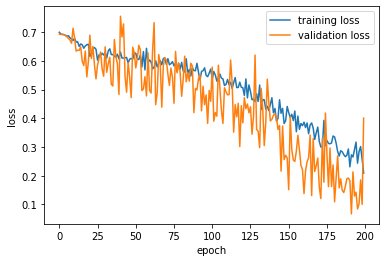

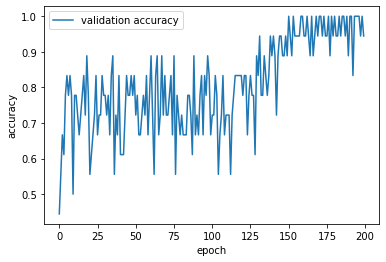

In [21]:
plt.figure()

for loss_type in ['training', 'validation']:
    
    _loss = gathered_loss[loss_type]
    
    plt.plot(np.arange(len(_loss)), _loss, label=loss_type + ' loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.figure()

_accuracy = gathered_loss["accuracy"]

plt.plot(np.arange(len(_accuracy)), _accuracy, label='validation accuracy')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()